# DLOps Assignment 1: ResNet and Layer-wise pretraining

Submitted By Debonil Ghosh [M21AIE225]

## Question 2 [20 marks]
(Question 1 later)

Implement a multi-layered classifier where weights of each layer is calculated greedily using
layer-wise pretraining with the help of auto-encoders on STL-10 dataset. Train a classifier having
X structure (excluding input and output layers) for classification task on the test set.
1. Report the classification accuracy on the test set and plot loss curves on the training and
evaluation set.
2. Report the class-wise accuracy of each class.
3. Plot t-sne for this model (use embeddings from layer X[3]) . Use the first 500 images of
each class from the test dataset for this visualization.
X = [1024,1200,728,512,128], if last digit of your roll no. is odd
X = [1024,1000,500,256, 128,64], if last digit of your roll no. is even
Reference - Slides [page number 11 to 14]

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn import metrics

In [98]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

traindataset = datasets.STL10('../downloads/', download=True, split='train', transform=transform)
testdataset = datasets.STL10('../downloads/', download=True, split='test', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [99]:
print(f'traindataset =>{traindataset.data.shape}')
print(f'testdataset =>{testdataset.data.shape}')

traindataset =>(5000, 3, 96, 96)
testdataset =>(8000, 3, 96, 96)


In [100]:

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000, shuffle=False, num_workers=4)

torch.Size([1000, 1, 96, 96])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026400A03520>
Traceback (most recent call last):
  File "c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026400A03520>
Traceback (most recent call last):
  File "c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloade

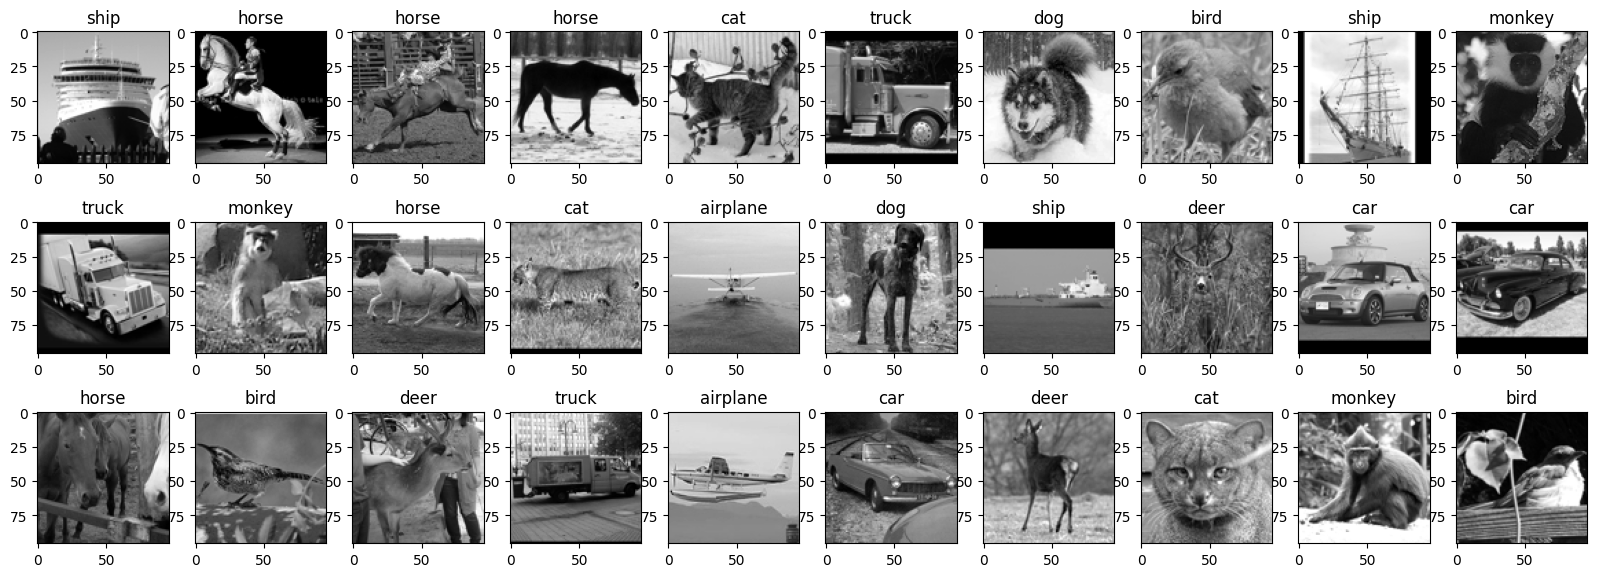

In [101]:
def view_samples():
    
    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        plot.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu(),cmap='gray')
    plt.show()
view_samples()

In [102]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize =(20,7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:,0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:,2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:,3], linestyle='-', label="Validation Accuracy" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()

In [103]:
# Train the model
def auto_encoder_model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, _ in trainloader:
            # Forward pass
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, images)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            #train_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, _ = next(iter(testloader))
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()*images.size(0)
            #val_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        #val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        #val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f},  \tTraining acc: {train_acc:.6f}, \tTest acc: {val_acc:.6f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    
    return np.array(loss_list)


In [104]:
# Train the model
def model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            # Forward pass
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            train_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, labels = next(iter(testloader))
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*images.size(0)
            val_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        #val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        #val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f},  \tTraining acc: {train_acc:.6f}, \tTest acc: {val_acc:.6f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    
    return np.array(loss_list)


In [105]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(Y_test,Y_pred_probs,k=5,labels=np.arange(10))

    plt.figure(figsize=(10, 10))
    plt.title(f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')

X = [1024,1200,728,512,128], as last digit of my roll no [M21AIE225] is odd

In [106]:
class autoencoder(nn.Module):
    input_size = 96*96
    hidden_sizes = [1024,1200,728,512]
    output_size = 128
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[2], self.hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[3], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[3], self.hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[2], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
vanila_ae = autoencoder()
print(vanila_ae)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=728, bias=True)
    (5): ReLU()
    (6): Linear(in_features=728, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=728, bias=True)
    (3): ReLU()
    (4): Linear(in_features=728, out_features=1200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1200, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=9216, bias=True)
    (9): Sigmoid()
  )
)


In [107]:
criterion = nn.MSELoss()
optimizer =  torch.optim.Adam(vanila_ae.parameters(), lr=0.001)

Epoch: 1 	Training Loss: 5.893572, 	Test Loss: 52.916259,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 2 	Training Loss: 5.052145, 	Test Loss: 50.696436,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 3 	Training Loss: 5.019078, 	Test Loss: 50.605915,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 4 	Training Loss: 5.096849, 	Test Loss: 51.794052,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 5 	Training Loss: 4.533762, 	Test Loss: 43.707684,  	Training acc: 0.000000, 	Test acc: 0.000000, 


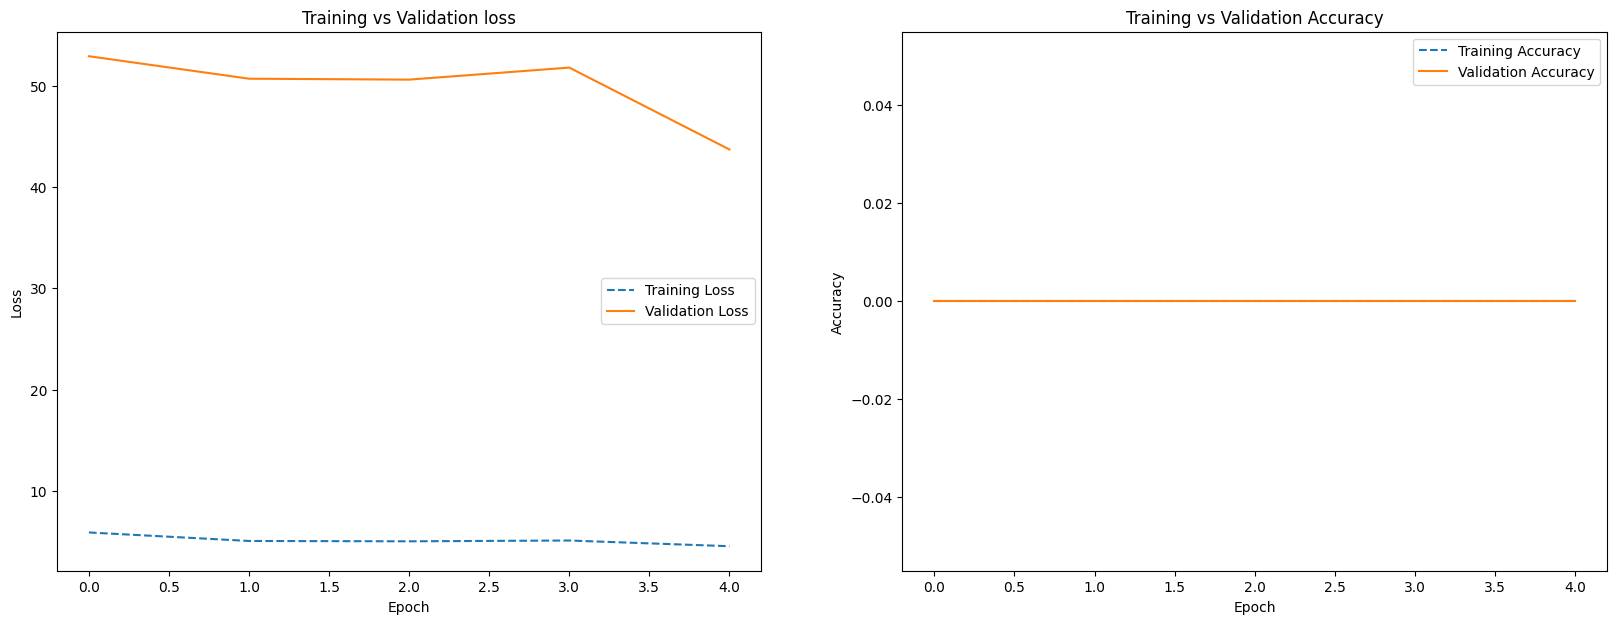

In [108]:
loss_list = auto_encoder_model_training(vanila_ae,criterion,optimizer,trainloader,testloader,num_epochs=5)
plot_training_graphs(loss_list)

For visualising AE performance

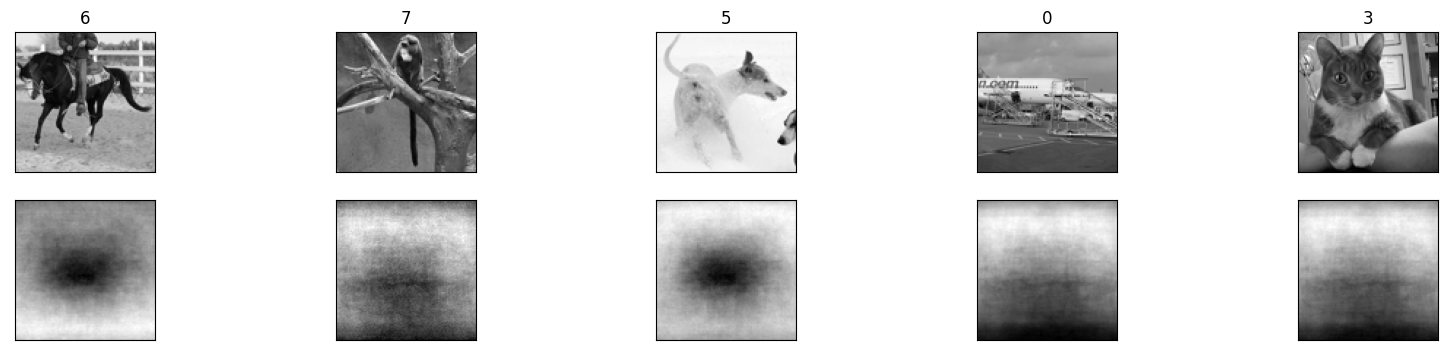

In [109]:
images, labels = next(iter(testloader))

img = images[0].view(1, 96*96)
with torch.no_grad():
    encoded = vanila_ae.encoder(images.view(-1, 96*96))
    decoded = vanila_ae.decoder(encoded)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(96, 96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(labels[i].numpy())
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(96, 96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [110]:
class image_classifier(nn.Module):
    num_classes = 10
    def __init__(self):
        super(image_classifier, self).__init__()
        self.encoder = vanila_ae.encoder
        self.fc = nn.Sequential(nn.Linear(vanila_ae.output_size, self.num_classes),
                      nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x
image_clf = image_classifier()
print(image_clf)

image_classifier(
  (encoder): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=728, bias=True)
    (5): ReLU()
    (6): Linear(in_features=728, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=128, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [111]:
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf =  torch.optim.Adam(image_clf.parameters(), lr=0.001)

Epoch: 1 	Training Loss: 221.259969, 	Test Loss: 2178.514957,  	Training acc: 0.161200, 	Test acc: 0.171000, 
Epoch: 2 	Training Loss: 215.402562, 	Test Loss: 2148.156404,  	Training acc: 0.170000, 	Test acc: 0.167000, 
Epoch: 3 	Training Loss: 212.804455, 	Test Loss: 2114.475489,  	Training acc: 0.195600, 	Test acc: 0.197000, 
Epoch: 4 	Training Loss: 207.931009, 	Test Loss: 2026.358366,  	Training acc: 0.208400, 	Test acc: 0.215000, 
Epoch: 5 	Training Loss: 200.072547, 	Test Loss: 2014.782906,  	Training acc: 0.229400, 	Test acc: 0.202000, 
Epoch: 6 	Training Loss: 195.836221, 	Test Loss: 2015.314817,  	Training acc: 0.240600, 	Test acc: 0.205000, 
Epoch: 7 	Training Loss: 193.681655, 	Test Loss: 1945.686460,  	Training acc: 0.254200, 	Test acc: 0.235000, 
Epoch: 8 	Training Loss: 189.338134, 	Test Loss: 1956.373096,  	Training acc: 0.270800, 	Test acc: 0.264000, 
Epoch: 9 	Training Loss: 185.133170, 	Test Loss: 1883.688569,  	Training acc: 0.298600, 	Test acc: 0.285000, 
Epoch: 10 

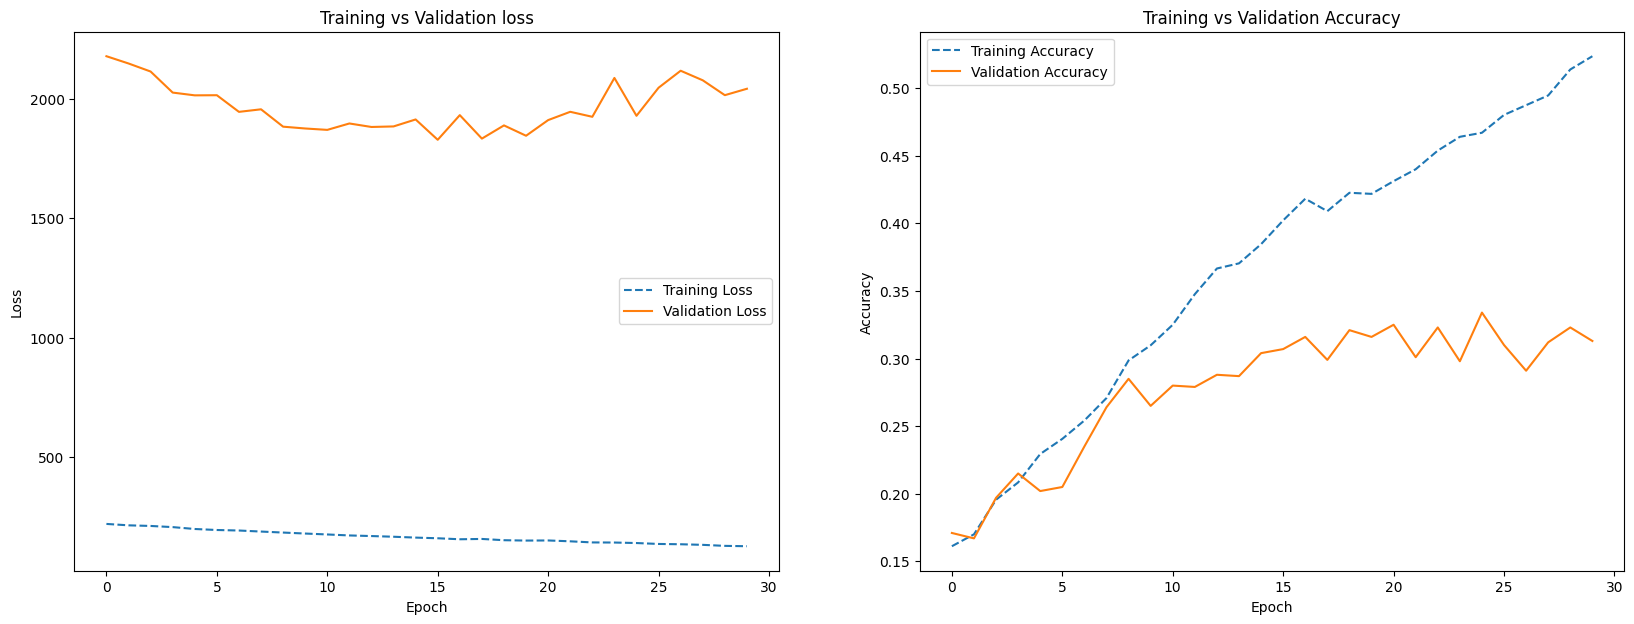

In [112]:
loss_list = model_training(image_clf,criterion_clf,optimizer_clf,trainloader,testloader,num_epochs=30)
plot_training_graphs(loss_list)

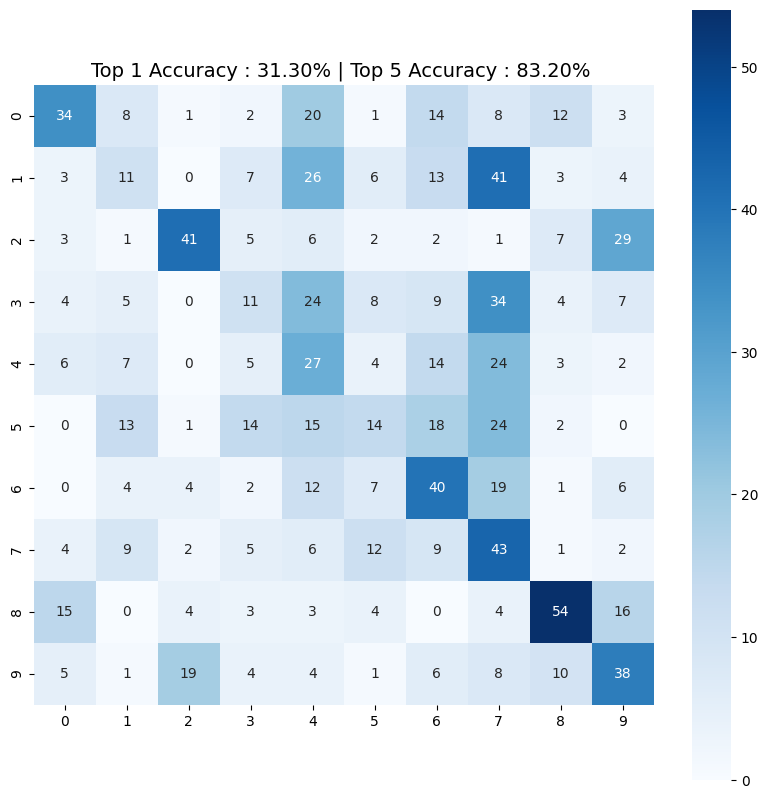

Top 1 Accuracy: 31.300%
Top 5 Accuracy: 83.2%
Classwise Accuracy Score: 
[0.33009709 0.09649123 0.42268041 0.10377358 0.29347826 0.13861386
 0.42105263 0.46236559 0.52427184 0.39583333]


In [113]:
test_images, test_labels = next(iter(testloader))
test_output = image_clf(test_images.view(-1, 96*96))
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output,testdataset.classes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


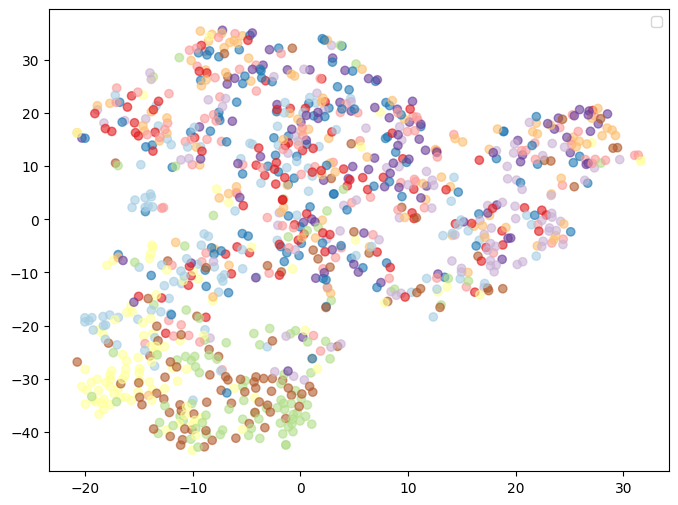

In [114]:
from sklearn.manifold import TSNE
images, labels = next(iter(testloader))

with torch.no_grad():
    test_encoded = vanila_ae.encoder(images.view(-1, 96*96))


plt.figure(figsize=(8, 6))
with torch.no_grad():
        X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=40).fit_transform(test_encoded)
        plt.scatter(X_embedded[:,0],X_embedded[:,1], c=test_labels,cmap="Paired", alpha = 0.6,marker='o')
plt.legend()
plt.show()

## Question 1 [80 marks]
Train ResNet18 on Tiny ImageNet dataset (download from here) with X as the optimizer for
classification task. Plot curves for training loss, training accuracy, validation accuracy and report
the final test accuracy. Here consider accuracy as top-5 accuracy.
1. Use CrossEntropy as the final classification loss function [10 marks]
2. Use Triplet Loss with hard mining as the final classification loss function [30 marks]
3. Use Central Loss as the final classification loss function [40 marks]
Compare the performance of different models and analyze the results in the report.

Note - The code for ResNet18 architecture and the loss functions needs to be implemented
from scratch. Directly importing from the library is not allowed and 0 marks will be awarded for
that.
X = Adam, if last digit of your roll no. is odd
X = SGD, if last digit of your roll no. is even

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from torch.autograd import Variable

RESNET 18 Hidden Layers

Use CrossEntropy as the final classification loss function [10 marks]

In [116]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [117]:
def cross_entropy_loss(logits, labels):
    softmax = nn.Softmax(dim=1)
    logsoftmax = nn.LogSoftmax(dim=1)
    loss = -logsoftmax(logits)
    loss = loss.gather(1, labels.view(-1, 1))
    loss = loss.mean()
    return loss


Hyperparameters

In [118]:
learning_rate = 0.1
batch_size = 20
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [119]:
import random
from torch.utils.data import Subset
train_dir = 'tiny-imagenet-200/train'
val_dir = 'tiny-imagenet-200/val'
test_dir = 'tiny-imagenet-200/test'
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
train_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#batch_size=100
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

classes = train_dataset.classes
train_indices = []
for c in classes:
    indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == classes.index(c)]
    indices = random.sample(indices, k=min(10, len(indices)))
    train_indices.extend(indices)
train_dataset = Subset(train_dataset, train_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val dataset
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_indices = []
for c in classes:
    indices = [i for i, (_, label) in enumerate(val_dataset.samples) if label == classes.index(c)]
    indices = random.sample(indices, k=min(10, len(indices)))
    val_indices.extend(indices)
val_dataset = Subset(val_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)
test_indices = []
for c in classes:
    indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == classes.index(c)]
    indices = random.sample(indices, k=min(10, len(indices)))
    test_indices.extend(indices)
test_dataset = Subset(test_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'tiny-imagenet-200/train'

In [ ]:
image, label = next(iter(train_loader))
print(image.shape)
print(label.shape)

In [ ]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=200).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.00001, weight_decay=5e-4)


In [ ]:
train_losses = []
train_accs = []
val_accs = []
#num_epochs= 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_total = 0
    train_correct = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        logits = model(images)
        loss = cross_entropy_loss(logits, labels)
        loss.backward()
        optimizer.step()
        #print(1)
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(logits.data, 1)
        train_total += labels.size(0)
        if torch.cuda.is_available():
            train_correct += (predicted.cpu().numpy() == labels.cpu().numpy()).sum().item()
        else:
            train_correct += (predicted.numpy() == labels.numpy()).sum().item()
    train_losses.append(train_loss / train_total)
    train_accs.append(train_correct / train_total)

    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            if torch.cuda.is_available():
              images=Variable(images.cuda())
              labels=Variable(labels.cuda())
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            val_total += labels.size(0)
            if torch.cuda.is_available(): 
                val_correct += (predicted.cpu().numpy() == labels.cpu().numpy()).sum().item()
            else:
                val_correct += (predicted.numpy() == labels.numpy()).sum().item()
            #print(2)
    val_acc = val_correct / val_total
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_acc:.4f}')


In [ ]:

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        logits = model(images)
        _, predicted = torch.topk(logits.data, k=5, dim=1)
        test_total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted[i]:
                test_correct += 1

test_acc= test_correct / test_total
print(f'Test Acc: {test_acc:.4f}')


Use Triplet Loss with hard mining as the final classification loss function [30 marks]

In [ ]:
import torch.nn.functional as F
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        loss = F.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()


In [ ]:
def train(model, criterion, optimizer, trainloader, valloader, num_epochs):
    train_losses = []
    train_top5_accs = []
    val_losses = []
    val_top5_accs = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct_top1 = 0
        correct_top5 = 0

        for i, (anchors, positives, negatives) in enumerate(trainloader):
            optimizer.zero_grad()
            anchors, positives, negatives = anchors.cuda(), positives.cuda(), negatives.cuda()
            outputs_anchor, outputs_positive, outputs_negative = model(anchors), model(positives), model(negatives)
            loss = criterion(outputs_anchor, outputs_positive, outputs_negative)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * anchors.size(0)
            total += anchors.size(0)

            # Compute top-1 and top-5 accuracy
            _, predicted = outputs_anchor.topk(5, 1, True, True)
            predicted = predicted.t()
            correct = predicted.eq(outputs_anchor.topk(1, 1, True, True)[1].t())
            correct_top1 += correct[0].sum().item()
            correct_top5 += correct[:5].sum().item()

            if i % 100 == 99:
                print('[Epoch %d, Batch %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / total))
                train_losses.append(running_loss / total)
                train_top5_accs.append(100.0 * correct_top5 / total)
                running_loss = 0.0
                total = 0
                correct_top1 = 0
                correct_top5 = 0

        # Compute validation loss and accuracy
        model.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            total_val = 0
            correct_top1_val = 0
            correct_top5_val = 0

            for j, (inputs, targets) in enumerate(valloader):
                inputs, targets = inputs.cuda(), targets.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                running_loss_val += loss.item() * inputs.size(0)
                total_val += inputs.size(0)

                # Compute top-1 and top-5 accuracy
                _, predicted_val = outputs.topk(5, 1, True, True)
                predicted_val = predicted_val.t()
                correct_val = predicted_val.eq(targets.view(1, -1).expand_as(predicted_val))
                correct_top1_val += correct_val[0].sum().item()
                correct_top5_val += correct_val[:5].sum().sum().item()

                if j % 100 == 99:
                    print('[Validation, Batch %5d] loss: %.3f' % (j + 1, running_loss_val / total_val))

            val_losses.append(running_loss_val / total_val)
            val_top5_accs.append(100.0 * correct_top5_val / total_val)

        model.train()

    return train_losses, train_top5_accs, val_losses, val_top5_accs



In [ ]:
def test(model, testloader):
    total = 0
    correct_top5 = 0

    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)

            # Compute top-5 accuracy
            _, predicted = outputs.topk(5, 1, True, True)
            predicted = predicted.t()
            correct = predicted.eq(labels.view(1, -1).expand_as(predicted))
            correct_top5 += correct[:5].sum().item()
            total += labels.size(0)

    model.train()

    print('Test accuracy (top-5): %.2f%%' % (100.0 * correct_top5 / total))
    return correct_top5 / total


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block, layers=[2, 2, 2, 2], num_classes=200):
        #super(TripletLoss, self).__init__()
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
def train_triplet(model, trainloader, margin, optimizer, epoch):
    model.train()

    losses = []
    correct = 0
    total = 0

    for batch_idx, (anchor_images, anchor_labels) in enumerate(trainloader):
        anchor_images, anchor_labels = anchor_images.cuda(), anchor_labels.cuda()

        optimizer.zero_grad()

        # Forward pass to compute anchor embeddings
        anchor_embeddings = model(anchor_images)

        # Select positive and negative examples for each anchor
        pos_mask = (anchor_labels.unsqueeze(1) == anchor_labels.unsqueeze(0)).float()
        neg_mask = (1 - pos_mask).float()

        pos_indices = pos_mask.nonzero()[:, 1]
        neg_indices = neg_mask.nonzero()[:, 1]

        if len(pos_indices) == 0 or len(neg_indices) == 0:
            continue

        # Compute positive and negative embeddings
        pos_embeddings = anchor_embeddings[pos_indices]
        neg_embeddings = anchor_embeddings[neg_indices]

        # Compute triplet loss
        triplet_loss = torch.clamp(torch.norm(anchor_embeddings.unsqueeze(1) - pos_embeddings.unsqueeze(0), dim=2) -
                                    torch.norm(anchor_embeddings.unsqueeze(1) - neg_embeddings.unsqueeze(0), dim=2) +
                                    margin, min=0.0).mean()

        # Backward pass and optimization
        triplet_loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = anchor_embeddings.max(1)
        total += anchor_labels.size(0)
        correct += predicted.eq(anchor_labels).sum().item()

        # Print progress
        if batch_idx % 100 == 0:
            print('Epoch: %d [%d/%d]\tLoss: %.4f\tAcc: %.2f%%' % (epoch, batch_idx, len(trainloader), 
                                                                  triplet_loss.item(), 100.0 * correct / total))
        
        losses.append(triplet_loss.item())

    train_acc = 100.0 * correct / total
    train_loss = sum(losses) / len(losses)
    return train_loss, train_acc



In [ ]:
def validate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.topk(outputs, k=5, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1, 1)).sum().item()
    model.train()
    return 100.0 * correct / total

In [ ]:
import matplotlib.pyplot as plt
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = ResNet18(500).to(device)

# Define the loss function and optimizer
margin = 0.2
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Define the number of epochs
num_epochs = 20

# Initialize lists to store the loss and accuracy
train_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(num_epochs):
    train_loss, train_acc = train_triplet(model, train_loader, margin, optimizer, epoch)
    val_acc = validate(model, val_loader)
    print('Epoch: %d\tTrain Loss: %.4f\tTrain Acc: %.2f%%\tVal Acc: %.2f%%' % 
          (epoch, train_loss, train_acc, val_acc))
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

# Test the model
test_acc = test(model, test_loader)


In [ ]:

# Plot the curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Test accuracy (top-5): %.2f%%' % (100.0 * test_acc))


Use Central Loss as the final classification loss function

In [ ]:
# Define ResNet18 model architecture
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )


In [ ]:

# Define Central Loss function
class CentralLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, alpha=0.5):
        super(CentralLoss, self).__init__()

        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.alpha = alpha
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, feat, label):
        centers_batch = self.centers.index_select(dim=0, index=label.long())

        diff = feat - centers_batch
        loss = torch.sum(torch.pow(diff, 2), dim=1) / 2.0
        intra_num = torch.histc(label.float(), bins=self.num_classes, min=0, max=self.num_classes-1)
        intra_num = torch.clamp(intra_num, min=1)

        centers_update = []
        for i in range(self.num_classes):
            if intra_num[i] == 1:
                centers_update.append(self.centers[i])
            else:
                centers_update.append(torch.mean(feat[label == i], dim=0))

        centers_update = torch.stack(centers_update)
        diff_centers = self.centers - centers_update
        diff_centers_norm = torch.sqrt(torch.sum(torch.pow(diff_centers, 2), dim=1) + 1e-12)

        loss_cent = torch.sum(diff_centers_norm) / 2.0
        loss *= self.alpha
        loss_cent *= (1 - self.alpha)

        return loss + loss_cent, centers_update












In [ ]:
# Define dataset and dataloader
class TinyImageNetDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def load_data(self):
        with open(self.file_path + '/wnids.txt', 'r') as f:
            self.classes = f.readlines()
        self.classes = [c.strip() for c in self.classes]

        for c in self.classes:
            for i in range(500):
                img_path = self.file_path + '/train/' + c + '/' + c + '_' + str(i) + '.JPEG'
                img = Image.open(img_path)
                self.data.append(img)
                self.labels.append(self.classes.index(c))

        self.test_data = []
        self.test_labels = []
        with open(self.file_path + '/val/val_annotations.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split('\t')
                img_path = self.file_path + '/val/images/' + parts[0]
                img = Image.open(img_path)
                self.test_data.append(img)
                self.test_labels.append(self.classes.index(parts[1]))

        assert len(self.data) == 500 * len(self.classes)
        assert len(self.test_data) == 10000


In [ ]:
# Define training function
def train(model, criterion, optimizer, dataloader, epoch):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            _, outputs = model(inputs)
            _, preds = torch.topk(outputs, k=5, dim=1)
            loss, _ = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.any(preds == labels.view(-1,1), dim=1)).item()

        if i % 100 == 99:
            epoch_loss = running_loss / ((i+1) * inputs.size(0))
            epoch_acc = running_corrects / ((i+1) * inputs.size(0))
            print('Epoch [{}/{}], Iter [{}/{}], Loss: {:.4f}, Top-5 Accuracy: {:.4f}'.format(epoch+1, num_epochs, i+1, len(dataloader), epoch_loss, epoch_acc))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}, Top-5 Accuracy: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
# Define testing function
def test(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            _, outputs = model(inputs)
            _, preds = torch.topk(outputs, k=5, dim=1)
            running_corrects += torch.sum(torch.any(preds == labels.view(-1,1), dim=1)).item()

    test_acc = running_corrects / len(dataloader.dataset)
    print('Test Top-5 Accuracy: {:.4f}'.format(test_acc))
    return test_acc


In [ ]:
# Define hyperparameters and instantiate model
num_classes = 200
batch_size = 128
num_epochs = 10
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet18(num_classes).to(device)

# Define loss function and optimizer
criterion = CentralLoss(num_classes, 512).to(device)
optimizer = torch.optim.SGD([{'params': model.parameters()}, {'params': criterion.parameters()}], lr=lr, momentum=momentum, weight_decay=weight_decay)

# Define data transforms and instantiate datasets and dataloaders
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=64, padding=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TinyImageNetDataset('tiny-imagenet-200', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_transforms = transforms.Compose([
    transforms.Resize(size=64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = TinyImageNetDataset('tiny-imagenet-200', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:

# Train
train_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    train_loss, train_acc = train(model, criterion, optimizer, train_loader, device, num_epochs)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    val_acc = test(model, test_loader)
    val_acc_history.append(val_acc)

    print()

test_acc = test(model, test_loader)

In [ ]:

# Plot loss and accuracy curves
plt.figure()
plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Top-5 Accuracy: {:.4f}'.format(test_acc))
